## This note describe how to analyze scRNA-seq data using NEN network analysis framework

## 0. Preparation
### 0.1 Import related python packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import ccnet as ccn
# import ccn

### 0.1 Prepare data
Extract the dataset Guo into folder 'Guo' and put it into the current directory. 

In [2]:
datafile = './Guo/data.csv'
timefile = './Guo/time_stages.csv'

Prepare related data, where 'data' is the normalized expression matrix with a shape of 438 cells * 38 genes,  in which rows and columns correspond to cells and genes. 'cell_names' and 'gene_names' are cell name list and gene name list, respectively. For other high-dimensional expression matrices, PCA is recommended for dimensionality reduction before processing to reduce noise and speed up calculation speed.

In [3]:
data_df = pd.read_csv(datafile, index_col=0)
data = np.array(data_df)
cell_names = data_df.index.values
gene_names = data_df.columns.values

The 'labels' here indicates the time stage of each cell.

In [4]:
time_df = pd.read_csv(timefile, index_col=None, header=None)
labels = time_df[0].to_list()

## 1 Analysis
### 1.1 Topological data analysis

Persistent Homology (PH) is the flagship tool of Topological Data Analysis (TDA). Before generating the network, the PH is calculated here to select the appropriate parameter T in the Non-uniform $\varepsilon$-Neighborhood (NEN) method. Different from the traditional PH, where the construction of the network (actually complex) is based on $\varepsilon$-Neighborhood (NEN), and here is based on NEN, which is more self-adaptive than EN. Note that the TDA here is not necessary because the parameter T in the NEN method already has a rough value range.

In [5]:
# compute Persistent Homology
intervals = ccn.homology(data, k=4, metric='euclidean')

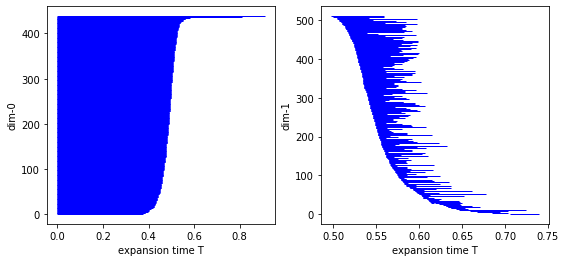

In [6]:
# display the result as persistence barcodes
fig, ax = plt.subplots(1, 2, figsize=(9,4))

ccn.plot(ax[0], intervals, xlabel='expansion time T', dim=0)
ccn.plot(ax[1], intervals, xlabel='expansion time T', dim=1)

#plt.savefig('figures_ph_guo/persistance_barcode.pdf', format='pdf')

In [7]:
# display the first 10 barcodes of the left above
list(reversed(intervals[0][-10:]))

[array([ 0., inf]),
 array([0.       , 0.8115648]),
 array([0.        , 0.58644992]),
 array([0.        , 0.58060718]),
 array([0.        , 0.56599903]),
 array([0.       , 0.5608719]),
 array([0.        , 0.56084186]),
 array([0.       , 0.5542202]),
 array([0.        , 0.55128253]),
 array([0.       , 0.5510332])]

From the above results, we can know that when the parameter $t \in [0.8115648, +\infty) $, the generated NEN network is connected, when $T \in [0.58644992, 0.8115648)$, the generated NEN network has two connected branches, and so on.

Alternatively, the result of PH can also be displayed as a persistence diagram

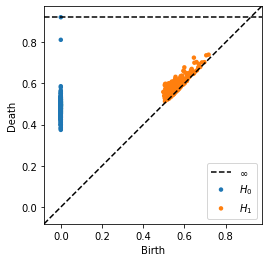

In [8]:
# display the result as persistence diagram
fig, ax = plt.subplots()
ccn.plot(ax, intervals, gtype ='diagram', dim=0)

### 1.2 Generating NEN network

Here we use the NEN method to generate the network. The parameter $k$ is the number of reference neighbors, which we set to 4. $T$ is the expansion time. $T$ take value roughly from 0.6 to 0.9, and the corresponding network changes from sparse to dense. Beyond this range, the generated network usually cannot approximate the intrinsic manifold of data appropriately. In order not to make the single-cell network too dense, we make $t = 0.61$. At the same time, in order to keep the generated network connected and facilitate downstream analysis, we combine the NEN network with a 2-neighbor network, and set the parameter $connected = true$, which repeatedly connects the nearest node between the two components until the whole network is connected.

In [9]:
# generate NEN network
adm = ccn.network(data, k=4, T=0.61, metric='euclidean', addknn=2, connected=True)

### 1.3 Network analysis

Statistical analysis of the network will help us to have a rough understanding of the structure of data. Some commonly used network statistics include node number, edge number, minimum degree, maximum degree, average degree, network radius, clustering coefficient, etc.

In [10]:
# compute some network statistics
ccn.statistics(adm)

{'n_nodes': 438,
 'n_edges': 3140,
 'min_deg': 2,
 'max_deg': 35,
 'mean_deg': 14.337899543378995}

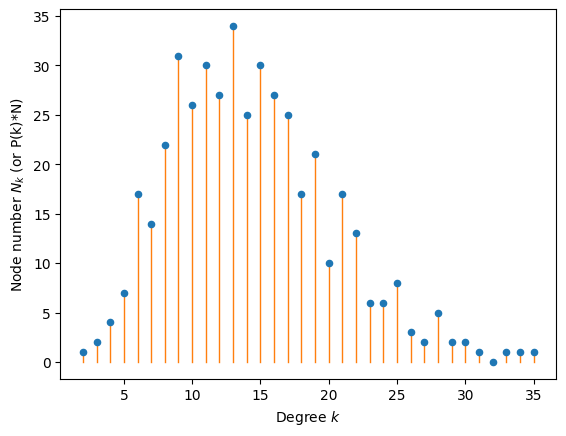

In [11]:
# display degree distribution
fig, ax = plt.subplots()

out = ccn.statistics(adm,ax, s=20)

### 1.4 Visualization

Here we use the network layout method ForceAtlas2 (FA2) to spatialize the network generated above. To prevent the overlapping between nodes, we call FA2 twice. When FA2 is called for the first time, we treated each node as a particle of zero size, namely, a particle without volume, thus producing a reasonable layout. On the basis of this layout, we call FA2 for the second time.

In [12]:
# network layout
pos = ccn.layout(adm, method='fa2', size=15, seed=4, 
                 niter1=2000, niter2=200, 
                 outbound1=False, outbound2=False, 
                 linlog1=False, linlog2=False)

 - 199 / range(0, 200)doneout ... 


If we know the index of the root cell or early developing cell, we can rotate the position so that the root cell is at the top of the layout.

In [13]:
# rotate the position
pos = ccn.rotate_pos(pos, root_ind=0)

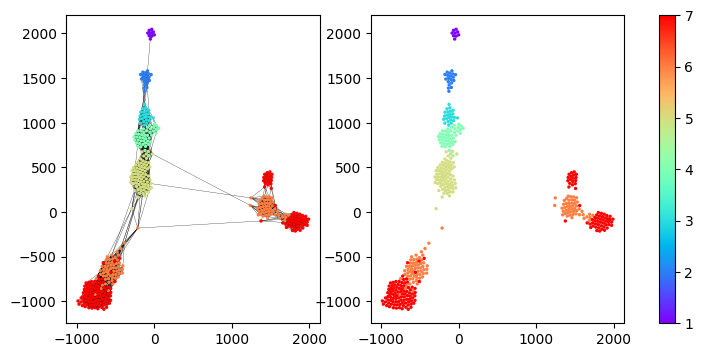

In [14]:
# visualize the network or data
fig, ax = plt.subplots(1,2, figsize=(9,4))

outax = ccn.plot_net(ax[0], pos, node_color=labels, node_size=2, edges=True, adm=adm)
outax = ccn.plot_net(ax[1], pos, node_color=labels, node_size=2, edges=False, adm=adm)
fig.colorbar(outax, ax=ax)

We can also export the network as a .gexf file and use Gephi to visualize it.

In [15]:
# uncomment the following codes to save the adjacency matrix as .gexf file
# import networkx as nx
# G = nx.from_numpy_matrix(adm)
# nx.write_gexf(G, "adm.gexf")

### 1.5 Clustering

We first weight the network, and then clustering through community detection. We describe two weighting strategies: by Sigmoid funcion and Jaccard similarity.

### 1.5.1 Weighting by Sigmoid function

In [16]:
wadms = ccn.sigmoid(adm, data, c=0.5, h=1.5, s=30)
labelss = ccn.leiden_cluster(wadms, resolution=1)

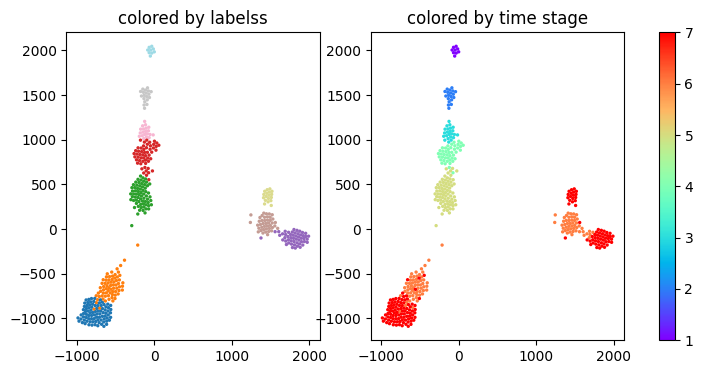

In [17]:
fig, ax = plt.subplots(1,2, figsize=(9,4))
outax = ccn.plot_net(ax[0], pos, node_color=labelss, cmap=plt.cm.tab20, node_size=2, edges=False, adm=adm)
ax[0].set_title('colored by labelss')

outax = ccn.plot_net(ax[1], pos, node_color=labels, node_size=2, edges=False, adm=adm)
ax[1].set_title('colored by time stage')
fig.colorbar(outax, ax=ax)

### 1.5.2 Weighting by Jaccard similarity

In [18]:
wadmj = ccn.jaccard_net(adm)
labelsj = ccn.leiden_cluster(wadmj, resolution=1)

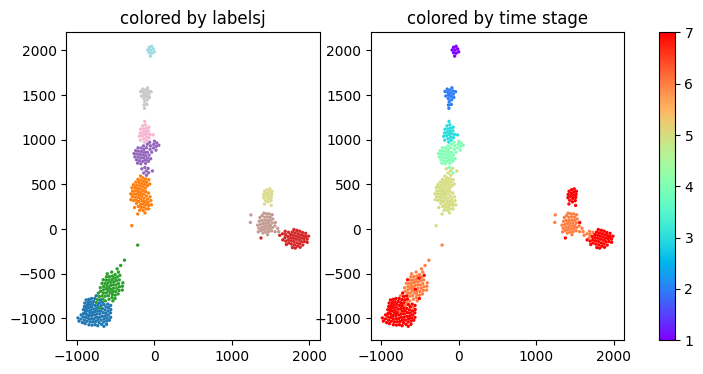

In [19]:
fig, ax = plt.subplots(1,2, figsize=(9,4))
outax = ccn.plot_net(ax[0], pos, node_color=labelsj, cmap=plt.cm.tab20, node_size=2, edges=False, adm=adm)
ax[0].set_title('colored by labelsj')

outax = ccn.plot_net(ax[1], pos, node_color=labels, node_size=2, edges=False, adm=adm)
ax[1].set_title('colored by time stage')
fig.colorbar(outax, ax=ax)

We can see that both strategies have well performance.

### 1.6 Pseudotime ordering

We first weight the edges by the expasion time, then define the pseudotime of each cell as its shortest path to the root cell.

In [20]:
# weight the network
wadm = ccn.network(data, k=4, T=0.61, addknn=2, connected=True, weighted=True)

In [21]:
# calculate the pseudotime
ordering = ccn.pseudotime(wadm, source=0)

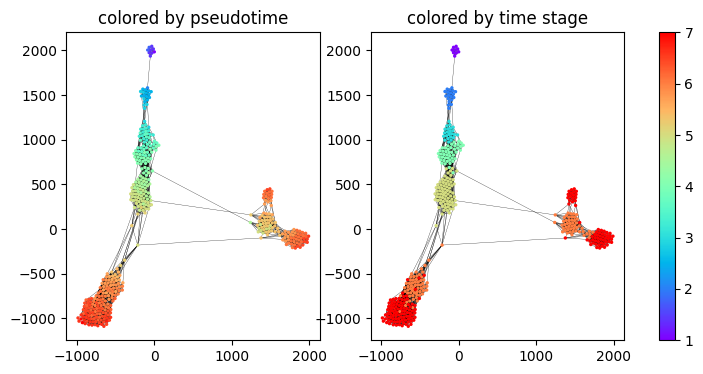

In [22]:
fig, ax = plt.subplots(1,2, figsize=(9,4))

outax = ccn.plot_net(ax[0], pos, node_color=ordering, node_size=2, edges=True, adm=adm)
ax[0].set_title('colored by pseudotime')

outax = ccn.plot_net(ax[1], pos, node_color=labels, node_size=2, edges=True, adm=adm)
ax[1].set_title('colored by time stage')
fig.colorbar(outax, ax=ax)

In [23]:
# Calculate the correlation coefficient between pseudotime and time stage
cs = [0,0,0]
cs[0] = ccn.pearson(ordering, labels)
cs[1] = ccn.spearman(ordering, labels)
cs[2] = ccn.kendall(ordering, labels)

print(' - pearson cor  = ', cs[0])
print(' - spearman cor = ', cs[1])
print(' - kendall cor  = ', cs[2])

 - pearson cor  =  0.9704203098840849
 - spearman cor =  0.9396021544316195
 - kendall cor  =  0.8415570490082743


### 1.7 Find trajectory-associated genes

Given the source and target cells, we can calculate the shortest path and consider it as the development trajectory from the former to the latter. Then we can find the genes related to this trajectory.

In [24]:
# given the source and target cells
source = 0
target = 414

Text(-383.46402582936105, -994.5491139043392, 'target cell')

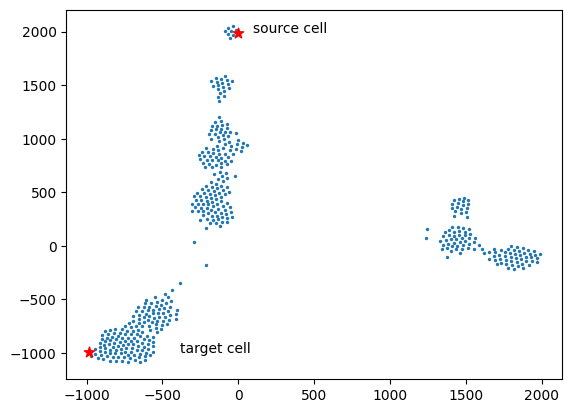

In [25]:
# display it
fig, ax = plt.subplots()
outax = ccn.plot_net(ax, pos, node_size=2, edges=False, adm=adm)

ax.scatter(pos[source,0], pos[source,1], c='red', s=60, marker="*")
ax.text(pos[source,0]+100, pos[source,1], 'source cell')


ax.scatter(pos[target,0], pos[target,1], c='red', s=60, marker="*")
ax.text(pos[target,0]+600, pos[target,1], 'target cell')

In [26]:
# calculate shortest path and trajectory-associated genes
path, genes = ccn.tags(wadm, data, ordering, gene_names, source=source, target=target)

c:\users\just\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


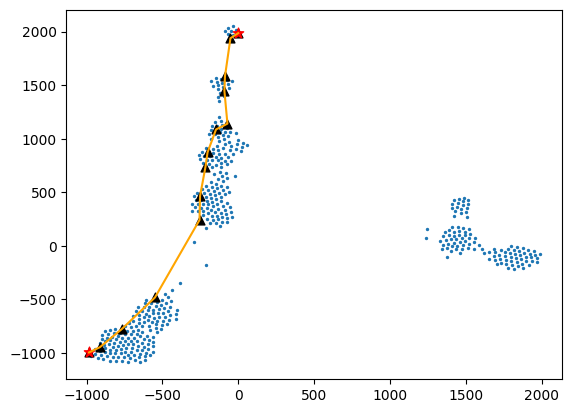

In [27]:
# display the trajectory
fig, ax = plt.subplots()

outax = ccn.plot_net(ax, pos, node_size=2, edges=False, adm=adm)

# path
ax.plot(pos[np.ix_(path, [0])], pos[np.ix_(path, [1])], c='orange')
ax.scatter(pos[np.ix_(path, [0])], pos[np.ix_(path, [1])], c='k', s=40, marker='^')

ax.scatter(pos[source,0], pos[source,1], c='red', s=60, marker="*")
ax.scatter(pos[target,0], pos[target,1], c='red', s=60, marker="*")

In [28]:
# some up-regulated genes
genes[:5]

[('Pecam1', (0.9731786769740108, 5.07317815270245e-09)),
 ('Snai1', (0.9382895360271941, 6.974437813717317e-07)),
 ('Gata4', (0.9162868056358145, 4.140412915980658e-06)),
 ('Sox2', (0.8700798439432822, 5.217529529257367e-05)),
 ('Tcfap2c', (0.8664370728302828, 6.108683801958664e-05))]

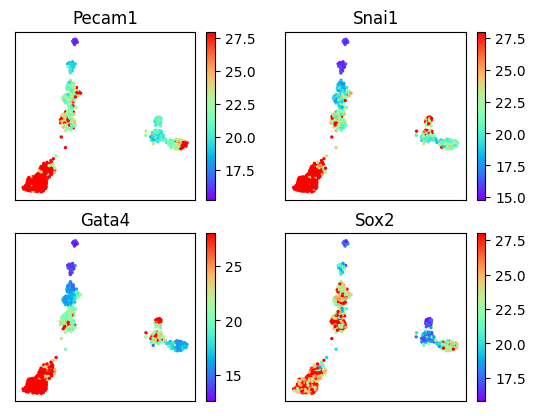

In [29]:
# colored by tarjectory-associated genes
fig, ax = plt.subplots(2, 2)

gs = ['Pecam1', 'Snai1', 'Gata4', 'Sox2']

for r in range(2):
    for c in range(2):
        num = r*2 + c
        outax = ccn.plot_net(ax[r,c], pos, node_color=data_df[gs[num]].tolist(), node_size=2, edges=False, adm=adm)
        ax[r,c].set_title(gs[num])
        
        # delete xticks and yticks
        ax[r,c].set_xticks(ticks=[])
        ax[r,c].set_yticks(ticks=[])
        
        fig.colorbar(outax, ax=ax[r,c])

In [30]:
# some down-regulated genes
genes[-5:]

[('Msc', (-0.47592401868769635, 0.08539495125053066)),
 ('Eomes', (-0.500590187413258, 0.06827662820681328)),
 ('Dab2', (-0.5589527354262376, 0.03771925327155879)),
 ('Sox17', (-0.6677908686465835, 0.009057610799022507)),
 ('Gata3', (-0.7553215145236574, 0.0017855981744744369))]

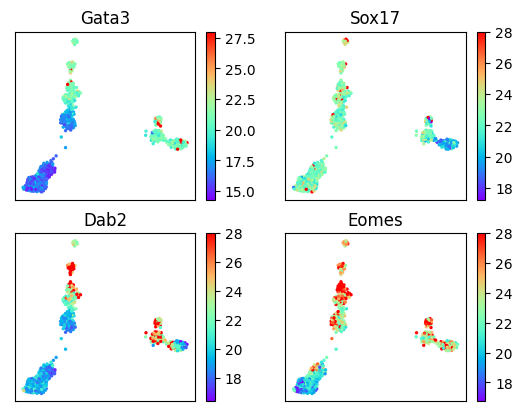

In [31]:
# colored by tarjectory-associated genes
fig, ax = plt.subplots(2, 2)

gs = ['Gata3', 'Sox17', 'Dab2', 'Eomes']

for r in range(2):
    for c in range(2):
        num = r*2 + c
        outax = ccn.plot_net(ax[r,c], pos, node_color=data_df[gs[num]].tolist(), node_size=2, edges=False, adm=adm)
        ax[r,c].set_title(gs[num])
        
        # delete xticks and yticks
        ax[r,c].set_xticks(ticks=[])
        ax[r,c].set_yticks(ticks=[])
        
        fig.colorbar(outax, ax=ax[r,c])